# Viés e imparcialidade no aprendizado de máquina
Parte 1: apresentando nosso conjunto de dados e o problema

Geralmente, o objetivo declarado de um problema de aprendizado de máquina é criar um pipeline de engenharia de recursos que maximize o desempenho de um modelo em um conjunto de dados. Nosso objetivo nesta série de artigos, no entanto, será não apenas monitorar e medir o desempenho do modelo, mas também acompanhar como nosso modelo trata diferentes grupos de dados porque, às vezes, os dados são pessoas .

Em nosso estudo de caso de hoje, os dados são pessoas cujas vidas estão em risco. Os dados são pessoas que simplesmente querem ter a melhor vida possível. Enquanto navegamos em torno de preconceito e discriminação, privilégio sistêmico e discrepâncias raciais, pedimos que você tenha em mente que, quando falamos de linhas, estamos falando de pessoas e, quando falamos de características, estamos falando de agregar anos se não décadas de experiências de vida em um único número, classe ou booleano . Devemos respeitar nossos dados e as pessoas que nossos dados representam.

Vamos começar.

# O conjunto de dados COMPAS

O conjunto de dados para este estudo de caso é o conjunto de dados Correctional Offender Management Profiling for Alternative Sanctions (COMPAS), que é uma coleção de criminosos rastreados no Condado de Broward, Flórida, nos anos de 2013–2014.
Em particular, estamos analisando um subconjunto desses dados que corresponde a um problema de classificação binária de previsão de reincidência (se uma pessoa reincidirá ou não) dadas certas características sobre um indivíduo.
Um link para o conjunto de dados pode ser encontrado aqui:
https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

À primeira vista, o problema é bastante simples. Classificação binária, sem dados perdidos, vamos lá! O problema surge quando nossos modelos de ML têm efeitos contrários muito reais na vida e no bem-estar das pessoas. Como engenheiros de ML e cientistas de dados, grande parte dessa carga recai sobre nós para criar modelos que não apenas apresentem bom desempenho, mas também gerem previsões que possam ser consideradas “justas”.

À medida que avançamos nesta aula, definiremos e quantificaremos “justo” de várias maneiras e, finalmente, uma decisão deve ser tomada sobre qual critério de imparcialidade é melhor para um determinado domínio de problema. Nosso objetivo nesta aula será apresentar várias definições de justiça e dar exemplos de como cada uma deve ser interpretada.

**Isenção de responsabilidade**:  este estudo de caso não representa um estudo estatístico nem deve ser usado para fazer generalizações sobre o sistema de justiça criminal dos Estados Unidos. Nosso objetivo é destacar instâncias de viés nos dados e promover ferramentas para maximizar a justiça em nossos sistemas de ML.

Vamos começar carregando nossos dados e dando uma olhada.

In [1]:
import pandas as pd
import numpy as np

compas_df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')


In [2]:
compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


As primeiras cinco linhas de nosso conjunto de dados COMPAS mostram algumas informações confidenciais sobre pessoas que foram encarceradas no Condado de Broward, Flórida. Nosso rótulo de resposta aqui é “two_year_recid”, que representa uma resposta à pergunta binária “essa pessoa voltou ao encarceramento dentro de 2 anos após ser libertada?”

No estudo original da ProPublica de 2016, que analisou a imparcialidade do algoritmo COMPAS, software e dados subjacentes, eles se concentraram na pontuação do decil dado a cada pessoa. Uma pontuação decil é uma pontuação de 1 a 10 que dimensiona os dados em intervalos de 10%. Se essa palavra parece um tanto familiar, é porque está intimamente relacionada à ideia de percentil. A ideia é que uma pessoa possa receber uma pontuação entre 1 e 10, onde cada pontuação representa uma parte de uma população na qual uma certa porcentagem de pessoas acima e abaixo tem uma classificação mais alta em uma métrica. Por exemplo, se dermos a alguém uma pontuação decil de 3, isso significa que 70% das pessoas devem ter um risco maior de reincidência (pessoas com pontuações de 4, 5, 6, 7, 8, 9 e 10) e 20% das pessoas têm menor risco de reincidência (pessoas com pontuações de 1 e 2). Da mesma forma, uma pontuação de 7 significa que 30% das pessoas têm uma taxa de reincidência mais alta (pessoas com pontuação de 8, 9, 10), enquanto 60% das pessoas têm uma taxa de reincidência menor (pessoas com pontuação de 1, 2, 3 , 4, 5,

O estudo foi além ao mostrar as disparidades entre como as pontuações em decis são usadas e como elas nem sempre parecem justas. Por exemplo, se observarmos como as pontuações são distribuídas, podemos ver que as pontuações são dadas de forma diferente por raça. O trecho a seguir traçará um histograma de pontuações de decis por raça e destaca algumas coisas:


1.   As pontuações dos decis dos afro-americanos estão distribuídas de maneira relativamente uniforme, com cerca de 10% da população residindo em cada pontuação do decil. Por definição de uma pontuação decil, isso é apropriado. 10% da população deveria, em teoria, viver em cada pontuação decil;
2.   As categorias Asiática, Caucasiana, Hispânica e Outras parecem ter uma inclinação certa nas pontuações decil, com uma porção maior do que o esperado da categoria tendo uma pontuação decil de 1 ou 2.

In [3]:
!pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=4250b5214775a67fcda6b3e22e4cf1af7af04d844a695946d257e20d51391729
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [4]:
import ydata_profiling

ydata_profiling.ProfileReport(compas_df)

Output hidden; open in https://colab.research.google.com to view.

<Axes: title={'center': 'Histograma de escore decil por raça'}, ylabel='% com escore decil'>

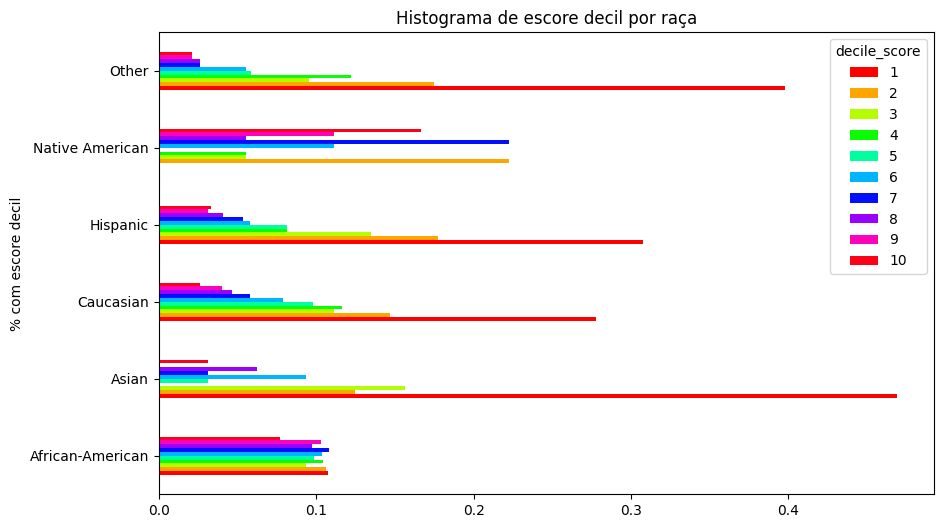

In [5]:
compas_df.groupby('race')['decile_score'].value_counts(
     normalize=True
 ).unstack().plot(
     kind='barh', figsize=(10, 6), cmap='hsv',
     title='Histograma de escore decil por raça', ylabel='% com escore decil'
 )

Podemos ver diferenças claras em como as pontuações por decil são distribuídas quando divididas por raça.

In [6]:
compas_df.groupby('race')['decile_score'].value_counts(normalize=True)

race              decile_score
African-American  7               0.108225
                  1               0.107684
                  2               0.106331
                  4               0.104167
                  6               0.103896
                  9               0.102814
                  5               0.098755
                  8               0.097132
                  3               0.093615
                  10              0.077381
Asian             1               0.468750
                  3               0.156250
                  2               0.125000
                  6               0.093750
                  8               0.062500
                  5               0.031250
                  7               0.031250
                  10              0.031250
Caucasian         1               0.277506
                  2               0.147107
                  4               0.116137
                  3               0.111247
                  5               0.098207
                  6               0.079055
                  7               0.058272
                  8               0.046455
                  9               0.039935
                  10              0.026080
Hispanic          1               0.307692
                  2               0.177394
                  3               0.135008
                  4               0.081633
                  5               0.081633
                  6               0.058085
                  7               0.053375
                  8               0.040816
                  10              0.032967
                  9               0.031397
Native American   2               0.222222
                  7               0.222222
                  10              0.166667
                  6               0.111111
                  9               0.111111
                  3               0.055556
                  4               0.055556
                  8               0.055556
Other             1               0.397878
                  2               0.175066
                  4               0.122016
                  3               0.095491
                  5               0.058355
                  6               0.055703
                  7               0.026525
                  8               0.026525
                  9               0.021220
                  10              0.021220
Name: proportion, dtype: float64

In [7]:
# Os tribunais geralmente usam uma pontuação de decil 5 para rotular alguém como sendo de risco médio.
compas_df['is_med_or_high_risk'] = (compas_df['decile_score']>=5).astype(bool)

In [8]:
# Não é ótimo se o sistema do tribunal retorna 5 ou mais na pontuação do decil preciso apenas 65% das vezes
(compas_df['is_med_or_high_risk']==compas_df['two_year_recid']).mean()

np.float64(0.6537288605489326)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.1)
sns.set_style('whitegrid')

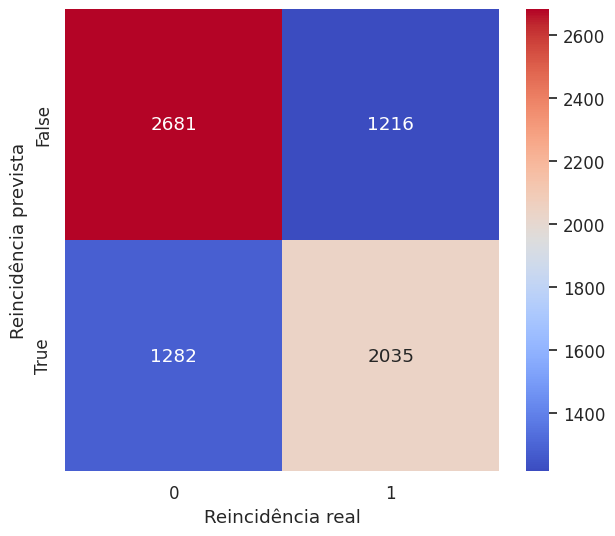

In [10]:
# heatmap de reincidência
cm = pd.crosstab(
    compas_df['is_med_or_high_risk'], compas_df['two_year_recid'],
    rownames=['Reincidência prevista'], colnames=['Reincidência real'],
    normalize=False
)
p = plt.figure(figsize=(7,6))
p = sns.heatmap(cm, annot=True, cmap="coolwarm", fmt='d')

In [11]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
reincidencia_ = (
    pd.read_csv(url)
    [['age_cat', 'sex', 'race', 'decile_score', 'score_text', 'two_year_recid']]
    .loc[lambda x:x.race.isin(['African-American', 'Caucasian'])]
    .assign(COMPAS_Decision=lambda x:x['score_text'].replace({'Low': 0, 'Medium':1, 'High': 1}))
)

<ipython-input-11-549e24325635>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .assign(COMPAS_Decision=lambda x:x['score_text'].replace({'Low': 0, 'Medium':1, 'High': 1}))


O algoritmo COMPAS, no conjunto de dados como um todo, é relativamente equilibrado. Listamos algumas observações sobre as decisões dos algoritmos COMPAS, em média, para a população de estudo:

Metade dos réus previstos reincidiriam (e metade previu que não), o que é ligeiramente menor do que a proporção real de reincidentes.

35% da população experimentou uma decisão incorreta, aproximadamente equilibrada entre falsos positivos e falsos negativos.

A tabela abaixo resume essas estatísticas:

In [12]:
pd.crosstab(reincidencia_['COMPAS_Decision'], reincidencia_['two_year_recid'], normalize=True, margins=True)

two_year_recid,0,1,All
COMPAS_Decision,,,
0,0.346179,0.161463,0.507642
1,0.187642,0.304715,0.492358
All,0.533821,0.466179,1.000000


In [13]:
b_recid = reincidencia_[reincidencia_['race'] == 'African-American']
w_recid = reincidencia_[reincidencia_['race'] == 'Caucasian']

pd.concat([
    pd.crosstab(b_recid['COMPAS_Decision'], b_recid['two_year_recid'], normalize=True, margins=True),
    pd.crosstab(w_recid['COMPAS_Decision'], w_recid['two_year_recid'], normalize=True, margins=True)
], axis=1, keys=['Black', 'White'])

Black                         White                    
two_year_recid          0         1       All         0         1       All
COMPAS_Decision                                                            
0                0.267857  0.143939  0.411797  0.464140  0.187857  0.651997
1                0.217803  0.370400  0.588203  0.142217  0.205786  0.348003
All              0.485660  0.514340  1.000000  0.606357  0.393643  1.000000

In [14]:
from sklearn import metrics

def calc_metrics(df):

    conf = metrics.confusion_matrix(df.two_year_recid, df.COMPAS_Decision)
    TP = conf[1,1]
    TN = conf[0,0]
    FP = conf[0,1]
    FN = conf[1,0]

    fnr = FN / (TP + FN)
    fpr = FP / (FP + TN)
    acc = (TP + TN) / (TP + TN + FP + FN)

    return pd.Series({'FNR': fnr, 'FPR': fpr, 'ACC': acc})

pd.concat([
    calc_metrics(reincidencia_).rename('ALL').to_frame().T,
    reincidencia_.groupby('race').apply(calc_metrics)
])

<ipython-input-14-c13e5318d598>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reincidencia_.groupby('race').apply(calc_metrics)


,FNR,FPR,ACC
ALL,0.346355,0.351508,0.650894
African-American,0.279853,0.448468,0.638258
Caucasian,0.477226,0.234543,0.669927


In [15]:
from sklearn.metrics import classification_report

In [16]:
print(classification_report(b_recid['COMPAS_Decision'], b_recid['two_year_recid']))

              precision    recall  f1-score   support

           0       0.55      0.65      0.60      1522
           1       0.72      0.63      0.67      2174

    accuracy                           0.64      3696
   macro avg       0.64      0.64      0.63      3696
weighted avg       0.65      0.64      0.64      3696



In [17]:
# utilizar classification_report aqui
print(classification_report(w_recid['COMPAS_Decision'], w_recid['two_year_recid']))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1600
           1       0.52      0.59      0.55       854

    accuracy                           0.67      2454
   macro avg       0.64      0.65      0.65      2454
weighted avg       0.68      0.67      0.67      2454



In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
confusao_black = confusion_matrix(y_true=b_recid['COMPAS_Decision'], y_pred=b_recid['two_year_recid'])

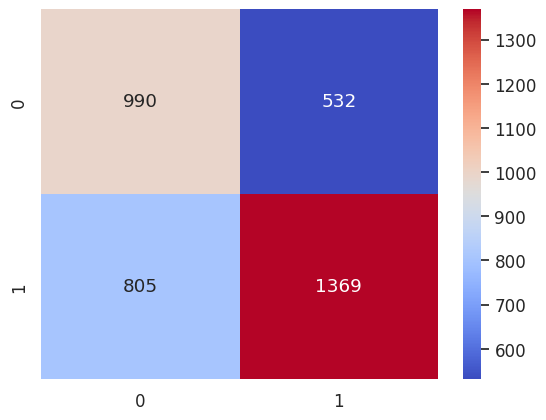

In [20]:
eixos_black = sns.heatmap(confusao_black, annot=True, cmap='coolwarm', fmt='d')

In [21]:
confusao_cauc = confusion_matrix(y_true=w_recid['COMPAS_Decision'], y_pred=w_recid['two_year_recid'])

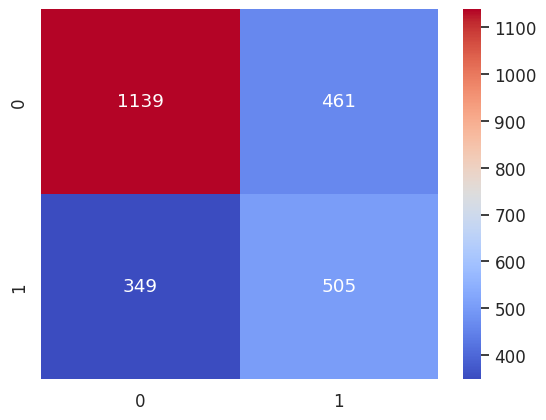

In [22]:
eixos_cauc = sns.heatmap(confusao_cauc, annot=True, cmap='coolwarm', fmt='d')

In [23]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
reincidencia_ = (
    pd.read_csv(url)
    .drop(['name', 'first', 'last'], axis=1)
    .assign(pred_recid_=lambda x:x['score_text'].isin(['Medium', 'High']).astype(int))
)

<ipython-input-24-05aaab126cb0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=a, x='race', y='pred_recid_', palette='hsv')


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Other'),
  Text(1, 0, 'African-American'),
  Text(2, 0, 'Caucasian'),
  Text(3, 0, 'Hispanic'),
  Text(4, 0, 'Native American'),
  Text(5, 0, 'Asian')])

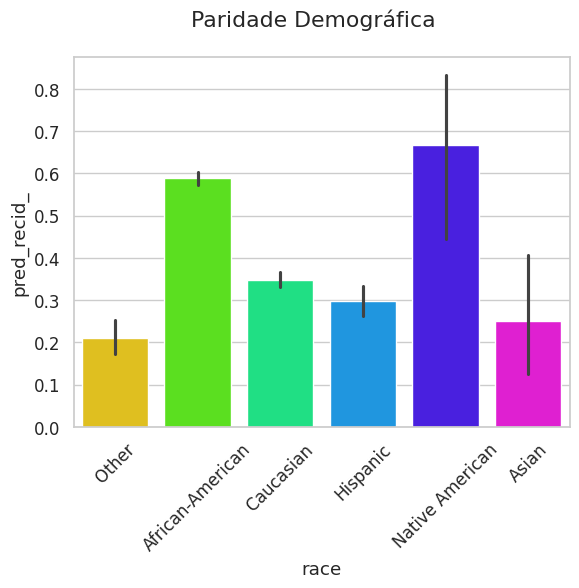

In [24]:
#sns.set_style('whitegrid')
a = reincidencia_
sns.barplot(data=a, x='race', y='pred_recid_', palette='hsv')
plt.suptitle('Paridade Demográfica')
plt.xticks(rotation=45)

Podemos ver isso mais claramente inspecionando algumas estatísticas básicas sobre pontuações de decis por raça:

In [25]:
compas_df.groupby('race')['decile_score'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,5.368777,2.831122,1.0,3.00,5.0,8.00,10.0
Asian,32.0,2.937500,2.601953,1.0,1.00,2.0,3.50,10.0
Caucasian,2454.0,3.735126,2.597926,1.0,1.00,3.0,5.00,10.0
Hispanic,637.0,3.463108,2.599100,1.0,1.00,3.0,5.00,10.0
Native American,18.0,6.166667,2.975389,2.0,3.25,7.0,8.75,10.0
Other,377.0,2.949602,2.350895,1.0,1.00,2.0,4.00,10.0


Observando as médias e medianas das pontuações em decil por raça, podemos ver, por exemplo, que a pontuação média em decil para afro-americanos é 5 (o que é esperado), mas para caucasianos e hispânicos é 3.

Poderíamos continuar analisando como o estudo ProPublica interpretou esses dados, mas, em vez de tentar recriar esses resultados, nossa abordagem para esse conjunto de dados será focada na construção de um classificador binário com os dados, ignorando a pontuação do decil já dada às pessoas.

# A Declaração do Problema

Conforme mencionado na seção anterior, o problema de ML aqui é de classificação binária. O objetivo do nosso modelo pode ser resumido pela pergunta:

*“Dados certos aspectos sobre uma pessoa, podemos prever a reincidência de forma precisa e justa?”*

O termo com precisão deve ser fácil o suficiente. Temos muitas métricas para medir o desempenho do modelo, incluindo exatidão (acurácia), precisão e AUC. No entanto, quando se trata do termo “fairly”, precisaremos aprender alguns novos termos e métricas. Antes de entrarmos em como quantificar o viés e a imparcialidade, vamos primeiro fazer um pouco de EDA sabendo do problema em questão.

# Análise exploratória de dados

Nosso objetivo é modelar diretamente nosso rótulo de resposta `two_year_recid` com base nos recursos sobre as pessoas neste conjunto de dados. Especificamente, temos as seguintes características:

1. sex – qualitativo, binário “masculino” ou “feminino”;
2. age – relação quantitativa, em anos;
3. race – nominal qualitativo;
4. juv_fel_count – quantitativo, o número de delitos graves (crimes) juvenis anteriores que essa pessoa cometeu;
5. juv_misd_count – quantitativo, o número de delitos leves (contravenções) juvenis anteriores que essa pessoa cometeu;
6. juv_other_count – quantitativo, o número v de condenações juvenis que não são crime nem contravenção;
7. priors_count – quantitativo, o número de crimes anteriores cometidos;
8. c_charge_degree – qualitativo, binário, 'F' para crime e 'M' para contravenção.


E nosso rótulo de resposta:

1. two_year_recid – qualitativo, binário, esta pessoa reincidiu (cometeu outro crime) dentro de 2 anos, sim ou não.

Observe que temos três colunas separadas para contar delitos juvenis. Devemos observar que, para nossos modelos, podemos querer combiná-los em uma única coluna que simplesmente conte o número de delitos juvenis que essa pessoa cometeu.

Dada a nossa declaração do problema de criar um modelo preciso e justo, vejamos a repartição da reincidência por raça. Quando agrupamos nosso conjunto de dados por raça e observamos a taxa de reincidência, fica claro que existem diferenças nas “taxas básicas” de reincidência. Sem detalhar mais (por idade, antecedentes criminais etc.), existem grandes diferenças nas taxas de reincidência entre diferentes categorias raciais.

In [26]:
compas_df.describe()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,6907.000000,7192.000000,7214.000000,2316.000000,0.0,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,5501.255753,34.817993,0.067230,4.509565,0.090934,0.109371,3.472415,3.304763,57.731368,0.481148,20.269430,NaN,0.113529,4.509565,3.691849,3.472415,11.465068,553.436651,0.382867,0.450652
std,3175.706870,11.888922,0.473972,2.856396,0.485239,0.501586,4.882538,75.809505,329.740215,0.499679,74.871668,NaN,0.317261,2.856396,2.510148,4.882538,46.954563,399.020583,0.486120,0.497593
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-414.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2735.250000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.250000,0.000000,0.000000
50%,5509.500000,31.000000,0.000000,4.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,2.000000,0.000000,530.500000,0.000000,0.000000
75%,8246.500000,42.000000,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,5.000000,1.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,17.000000,38.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


In [27]:
compas_df.groupby('race')['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,0.514340,0.499862,0.0,0.0,1.0,1.0,1.0
Asian,32.0,0.281250,0.456803,0.0,0.0,0.0,1.0,1.0
Caucasian,2454.0,0.393643,0.488657,0.0,0.0,0.0,1.0,1.0
Hispanic,637.0,0.364207,0.481585,0.0,0.0,0.0,1.0,1.0
Native American,18.0,0.555556,0.511310,0.0,0.0,1.0,1.0,1.0
Other,377.0,0.352785,0.478472,0.0,0.0,0.0,1.0,1.0


Estatísticas descritivas de reincidência por raça vistas acima. Podemos ver uma clara diferença nas taxas de reincidência entre nossos diferentes grupos raciais

Também devemos observar que temos duas categorias de raça (asiáticas e nativas americanas) com representação extremamente pequena em nossos dados. Este é um exemplo de **viés de amostra** em que a população pode não ser representada adequadamente. Esses dados são retirados do Condado de Broward, Flórida, onde – de acordo com o censo dos EUA – aqueles que se identificam como asiáticos, por exemplo, constituem cerca de 4% da população; enquanto no conjunto de dados, eles representam cerca de 0,44% dos dados.

Para nossos propósitos nesta aula, rotularemos novamente os pontos de dados com raça como “asiáticos” ou “nativos americanos” e renomearemos sua raça como “outro” para evitar qualquer equívoco em nossas métricas em relação a ter duas categorias de raça sendo tão sub-representada. Nosso principal motivo para fazer essa nova rotulagem é tornar as classes resultantes mais equilibradas. Em nossa última figura, fica claro que as contagens de pessoas nas classes “asiáticas” e “nativas americanas” estão muito sub-representadas e, portanto, seria inapropriado tentar usar esse conjunto de dados para fazer previsões significativas sobre elas.

Depois de rotular novamente esses pontos de dados, vamos plotar as taxas reais de reincidência de 2 anos para nossas agora quatro categorias de raça consideradas.

In [28]:
# Renomear duas raças como Other.
# Apenas por razões educacionais e para evitar problemas com amostras distorcidas
compas_df.loc[compas_df['race'].isin(['Native American', 'Asian']), 'race'] = 'Other'

<Axes: title={'center': 'Taxas reais de reincidência por raça'}, ylabel='race'>

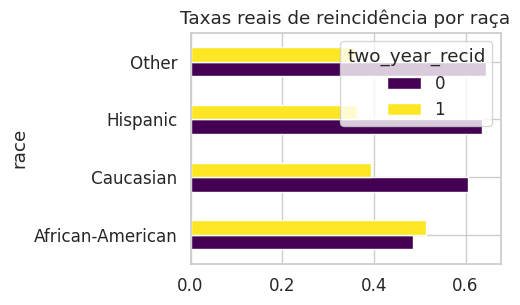

In [29]:
# Plotar taxas de reincidência
compas_df.groupby('race')['two_year_recid'].value_counts(normalize=True).unstack().plot(
     cmap='viridis', kind='barh', figsize=(4, 3), title='Taxas reais de reincidência por raça')

Mais uma vez, podemos ver que nossos dados mostram que os afro-americanos reincidem a uma taxa mais alta do que os caucasianos, hispânicos ou outros. A razão disso é o resultado de muitas razões sistêmicas diferentes que não podemos nem começar a abordar nesta aula. Por enquanto, observemos que, embora as taxas de reincidência sejam diferentes entre os grupos, a diferença entre uma divisão próxima de 50/50 para afro-americanos e a divisão de 60/40 para caucasianos não são taxas radicalmente diferentes.

**Disparidades em gênero**:  Também poderíamos ter escolhido observar o viés em "Sex", pois há definitivamente disparidades entre aqueles identificados como homens e mulheres neste conjunto de dados. Para os propósitos deste estudo de caso, optamos por focar nos vieses raciais presentes nos dados.

Vamos continuar examinando nossos outros atributos um pouco mais. Temos um atributo binário que teremos que codificar como um booleano, mas parece utilizável em sua forma atual:

<Axes: title={'center': '% grau do crime'}, xlabel='Grau do crime', ylabel='%'>

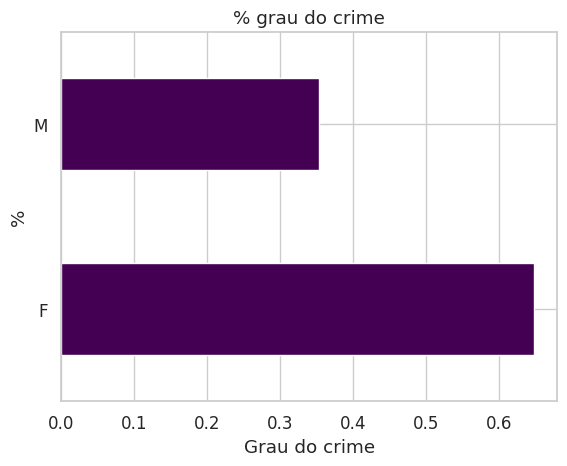

In [30]:
compas_df['c_charge_degree'].value_counts(normalize=True).plot(
     cmap='viridis', kind='barh', title='% grau do crime', ylabel='%', xlabel='Grau do crime')

Observa-se no gráfico acima a distribuição de crimes e contravenções em nosso conjunto de dados por grau. Temos cerca de 65% de nossas acusações como F por crimes e o restante como M por contravenções.

Vamos encerrar nosso EDA observando um histograma de nossos atributos quantitativos restantes: age e priors_count. Ambas as variáveis ​​estão mostrando uma inclinação direita bastante clara e seria benéfico realizar alguma padronização para lidar um pouco com esses valores discrepantes.

<Axes: title={'center': 'Histograma de crimes anteriores'}, xlabel='Prévios', ylabel='Frequency'>

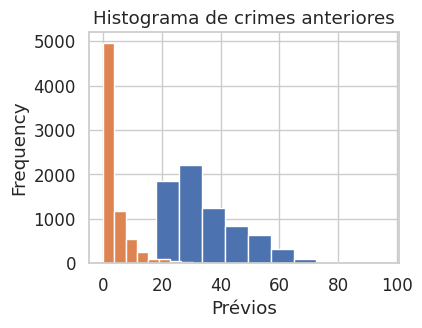

In [31]:
# Inclinação à direita em Age
compas_df['age'].plot(title='Histograma de idade', kind='hist', xlabel='Idade', figsize=(4, 3))

# Inclinação à direita em Priors
compas_df['priors_count'].plot(title='Histograma de crimes anteriores', kind='hist', xlabel='Prévios', figsize=(4, 3))

<Axes: title={'center': 'Histograma de crimes anteriores'}, xlabel='Prévios', ylabel='Frequency'>

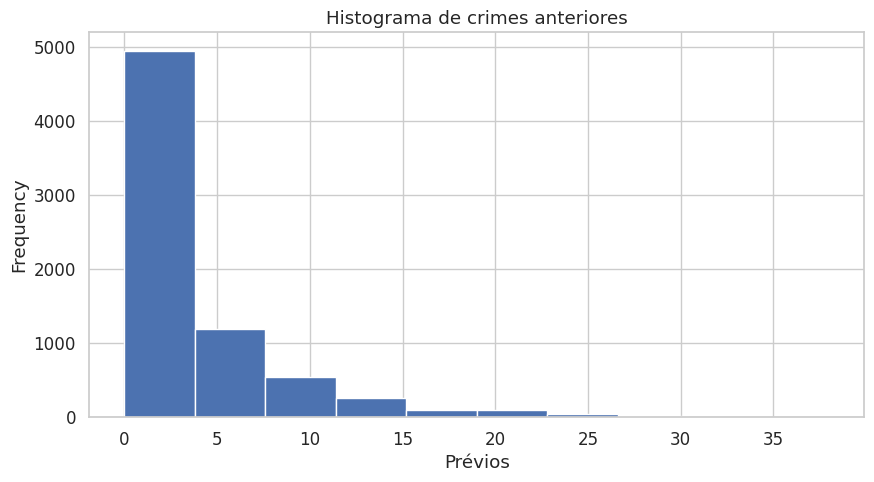

In [32]:
# Inclinação à direita em Priors
compas_df['priors_count'].plot(title='Histograma de crimes anteriores', kind='hist', xlabel='Prévios', figsize=(10, 5))

In [33]:
compas_df['age'].describe()

,age
count,7214.000000
mean,34.817993
std,11.888922
min,18.000000
25%,25.000000
50%,31.000000
75%,42.000000
max,96.000000


A contagem de idade e antecedentes mostra uma inclinação à direita nos dados. Está mostrando que a maioria das pessoas em nosso conjunto de dados está no lado jovem, mas temos alguns valores discrepantes puxando a média para a direita. Isso surgirá novamente quando investigarmos a imparcialidade do modelo.

Com nosso EDA nos dando uma visão inicial, vamos discutir e medir o viés e a imparcialidade de nossos modelos.

# Medindo o viés e a imparcialidade

Quando encarregados de tornar as previsões de modelo justas e imparciais, precisamos examinar algumas maneiras diferentes de formular e quantificar a imparcialidade para que possamos quantificar o desempenho de nossos modelos de ML.

# Tratamento Díspar vs Impacto Díspar

Em geral, um modelo – ou realmente qualquer processo preditivo/de tomada de decisão – pode sofrer de duas formas de viés: Tratamento Díspar (Disparate Treatment) e Impacto Díspar (Disparate Impact). Considera-se que um modelo sofre de Tratamento Díspar se as previsões forem de alguma forma baseadas em um atributo sensível (como gênero ou raça). Um modelo também pode ter um impacto díspar se as previsões/resultados das previsões prejudicarem ou beneficiarem desproporcionalmente pessoas com características sensíveis específicas que podem parecer prever taxas mais altas de reincidência para uma raça em relação a outra.

# Definições de Justiça (*Fairness*)

Existem pelo menos dezenas de maneiras de definir justiça em um modelo, mas vamos nos concentrar em três por enquanto e, quando estivermos construindo nosso modelo básico, as veremos novamente e mais delas.

# Desconhecimento/Inconsciência (*Unawareness*)

Desconhecimento/Inconsciência é provavelmente a definição mais fácil de justiça. Ele afirma que um modelo não deve incluir atributos confidenciais como um atributo nos dados de treinamento. Dessa forma, nosso modelo não terá acesso aos valores sensíveis ao treinar. Essa definição se alinha bem com a ideia de tratamento díspar, pois literalmente não estamos permitindo que o modelo veja os valores confidenciais de nossos dados.

A vantagem superficial de usar inconsciência como definição é que é muito fácil explicar a alguém que simplesmente não usamos um atributo em nosso modelo, portanto, como ele poderia ter obtido algum viés? O contra-argumento a esta afirmação e a principal falha de confiar na inconsciência para definir justiça é que, na maioria das vezes, o modelo será capaz de reconstruir valores sensíveis confiando em outros atributos altamente correlacionados com o atributo sensível original que estávamos tentando ignorar.

Por exemplo, se um recrutador está decidindo se deve ou não contratar um candidato e desejamos que ele seja sensível ao sexo do candidato, podemos simplesmente ocultara do recrutador o sexo do candidato; no entanto, se o recrutador também perceber que o candidato listou “fraternidades” como uma experiência anterior de voluntariado/liderança, o recrutador pode concluir razoavelmente que o candidato provavelmente é um homem.

# Paridade Estatística

A paridade estatística, também conhecida como paridade demográfica ou impacto díspar, é uma definição muito comum de justiça. Simplificando, ele afirma que a previsão do nosso modelo de estar em uma determinada classe (eles vão reincidir ou não) é independente do atributo sensível. Coloque como fórmula:

P(reincidência | raça=afro-americana) = P(reincidência | raça=caucasiana) = P(reincidência | raça=hispânica) = P(reincidência | raça=outro)

Em outras palavras, para obter uma boa paridade estatística, nosso modelo deve prever taxas iguais de reincidência para todas as categorias raciais. A fórmula acima é bastante rígida e, para relaxar, podemos nos apoiar na regra dos quatro quintos, que afirma que uma taxa de seleção (a taxa na qual prevemos a reincidência) para qualquer grupo desfavorecido, a proporção de nossas taxas de predição pode cair no faixa (0,8; 1/0,8) e ser considerado justa. Como uma fórmula, isso se parece com o seguinte.

0,8 < P(reincidência | raça=desfavorecido) / P(reincidência | raça=privilegiado) < 1/,8 (1,25)

As vantagens de usar a paridade estatística como uma definição de justiça é que é relativamente fácil explicar a métrica. Também há evidências de que usar Paridade Estatística como uma definição pode levar a benefícios de curto e longo prazo dos grupos desvantajosos: [A Short-term Intervention for Long-term
Fairness in the Labor Market](https://arxiv.org/pdf/1712.00064.pdf)).

Uma ressalva de confiar na paridade estatística é que ela ignora qualquer relação possível entre nosso rótulo e nosso atributo sensível. No nosso caso, isso é realmente uma coisa boa porque queremos ignorar qualquer correlação entre nossa resposta (essa pessoa reincidir) e nosso atributo sensível em questão (raça), pois essa correlação é impulsionada por fatores muito maiores do que nosso estudo de caso pode lidar. Para qualquer caso de uso, nossos leitores podem considerar no futuro, isso pode não ser desejado, portanto, leve isso em consideração!

Outra ressalva de confiar apenas na paridade estatística é que nosso modelo de ML em teoria poderia ser apenas “preguiçoso” e selecionar pessoas aleatórias de cada grupo e ainda atingiríamos tecnicamente a paridade estatística. Obviamente, nossas métricas de ML devem impedir que nossos modelos façam isso, mas é sempre algo a se observar.

# Probabilidades Equalizadas

Também conhecida como Paridade de Taxa Positiva (*Positive Rate Parity*), a definição de imparcialidade das Probabilidades Equalizadas afirma que a previsão de nosso modelo de nossa resposta deve ser independente de nosso atributo sensível condicional em nosso valor de resposta. No contexto do nosso exemplo, as probabilidades equalizadas significariam que as duas condições a seguir são atendidas:

P(reincidência | raça=hispânico, realmente reincidente=Verdadeiro) = P(reincidência | raça=Caucasiano, realmente reincidente=Verdadeiro) = P(reincidência | raça=Afro-americano, realmente reincidente=Verdadeiro) = P(reincidência | raça= Outro, realmente reincidente = Verdadeiro)

e

P(reincidência | raça=hispânica, realmente reincidente=Falso) = P(reincidência | raça=caucasiana, realmente reincidente=Falso) = P(reincidência | raça=afro-americana, realmente reincidente=Falso) = P(reincidência | raça= Outro, realmente reincidente=Falso)

**Outra maneira** de ver isso seria dizer que nosso modelo igualou as probabilidades se:

1. Independente da raça, nosso modelo previu taxas de reincidência igualmente para pessoas que realmente reincidiram;
2. Independente da raça, nosso modelo previu taxas de reincidência igualmente para pessoas que não reincidiram de fato.

A vantagem de usar probabilidades equalizadas para nossa definição é que isso penaliza a mesma “preguiça” de que falamos com Paridade Estatística. Isso incentiva o modelo a se tornar mais preciso em todos os grupos, em vez de permitir que o modelo simplesmente preveja aleatoriamente a reincidência para atingir taxas semelhantes de predição entre os grupos.

A maior falha é que essas probabilidades equalizadas são sensíveis a diferentes taxas básicas subjacentes da resposta. Em nossos dados, vimos que os afro-americanos reincidiram em uma taxa mais alta do que as outras três categorias raciais. Se esse fosse um cenário em que acreditássemos que havia algumas diferenças naturais entre os grupos raciais e as taxas de reincidência, as probabilidades igualadas não seriam uma boa métrica para nós. Em nosso caso, isso não será um problema, pois rejeitamos a ideia de que essas taxas básicas relacionadas a raça e reincidência refletem taxas naturais de reincidência.

**Outras métricas de imparcialidade**:  existem dezenas de métricas estabelecidas para medir a imparcialidade e o viés. Nosso estudo de caso aborda algumas delas, mas recomendamos a leitura de outros textos que se concentrem exclusivamente no viés/justiça para um tratamento abrangente.